## RBM unsupervised training example of MNIST using Persistent Contrastive Divergence (PCD-1).
Developed by: Jose Pinilla

In [1]:
# Required Packages
import qaml
import torch

import matplotlib.pyplot as plt

import torchvision.datasets as torch_datasets
import torchvision.transforms as torch_transforms

In [2]:
################################# Hyperparameters ##############################
EPOCHS = 5
BATCH_SIZE = 64
M,N = SHAPE = (28,28)
# Stochastic Gradient Descent
learning_rate = 1e-3
weight_decay = 1e-4
momentum = 0.5

In [3]:
#################################### Input Data ################################
train_dataset = torch_datasets.MNIST(root='./data/', train=True,
                                     transform=torch_transforms.ToTensor(),
                                     download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True)

test_dataset = torch_datasets.MNIST(root='./data/', train=False,
                                    transform=torch_transforms.ToTensor(),
                                    download=True)
test_loader = torch.utils.data.DataLoader(test_dataset)

In [4]:
################################# Model Definition #############################
VISIBLE_SIZE = M*N
HIDDEN_SIZE = 128

# Specify model with dimensions
rbm = qaml.nn.RBM(VISIBLE_SIZE, HIDDEN_SIZE)

# Set up optimizer
optimizer = torch.optim.SGD(rbm.parameters(), lr=learning_rate,
                                              weight_decay=weight_decay,
                                              momentum=momentum)
# Set up training mechanisms
sampler = qaml.sampler.GibbsNetworkSampler(rbm, BATCH_SIZE)
CD = qaml.autograd.ContrastiveDivergence()

In [5]:
################################## Model Training ##############################
# Set the model to training mode
rbm.train()
err_log = []
for t in range(EPOCHS):
    epoch_error = torch.Tensor([0.])
    for img_batch, labels_batch in train_loader:

        input_data = img_batch.flatten(1)

        # Positive Phase
        v0, p_h0 = sampler(input_data,k=0)
        # Negative Phase
        p_vk, p_hk = sampler(k=1)

        # Reconstruction error from Contrastive Divergence
        err = CD.apply(sampler, (v0,p_h0), (p_vk,p_hk), *rbm.parameters())

        # Do not accumulated gradients
        optimizer.zero_grad()
        # Compute gradients. Save compute graph at last epoch
        err.backward(retain_graph=(t == EPOCHS-1))

        # Update parameters
        optimizer.step()
        epoch_error  += err
    err_log.append(epoch_error.item())
    print(f"Epoch {t} Reconstruction Error = {epoch_error.item()}")

Epoch 0 Reconstruction Error = 78534.859375
Epoch 1 Reconstruction Error = 27791.2109375
Epoch 2 Reconstruction Error = 18152.427734375
Epoch 3 Reconstruction Error = 14738.3583984375
Epoch 4 Reconstruction Error = 13188.908203125


Text(0.5, 0, 'Epoch')

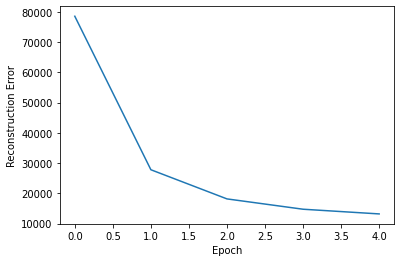

In [6]:
# Reconstruction error graph
fig, ax = plt.subplots()
plt.plot(err_log)
plt.ylabel("Reconstruction Error")
plt.xlabel("Epoch")

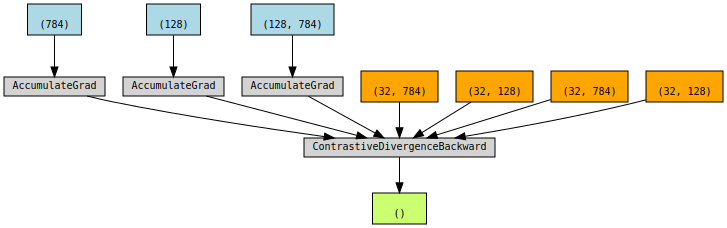

In [7]:
################################# VISUALIZE ####################################
# Computation Graph
from torchviz import make_dot
make_dot(err)

Plot the distribution of energies for (a) the training data, (b) the test data (c) a set of random samples of visible configurations. The expected result is to have both (a) and (b) as clusters of lower energy, and (c) as a normal distribution to the right, i.e. high energy.

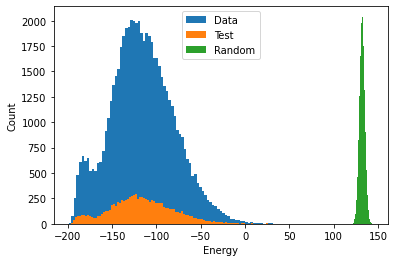

In [8]:
################################## ENERGY ######################################
data_energies = []
for img,_ in train_dataset:
    data_energies.append(rbm.free_energy(img.float().view(rbm.V)).item())

test_energies = []
for img,_ in test_dataset:
    test_energies.append(rbm.free_energy(img.float().view(rbm.V)).item())

rand_energies = []
for _ in range(len(train_dataset)):
    rand_energies.append(rbm.free_energy(torch.rand(rbm.V)).item())

plt.hist(data_energies,label="Data",bins=100)
plt.hist(test_energies,label="Test",bins=100)
plt.hist(rand_energies,label="Random",bins=100)
plt.ylabel("Count")
plt.xlabel("Energy")
plt.legend()

It's possible to sample from the joint probability of the model and plot the visible units of those samples. This doesn't necessarily sample an image of a number.

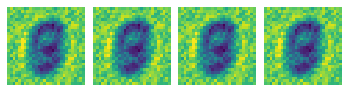

In [ ]:
################################## SAMPLE ######################################
SAMPLES=4
prob_vk,prob_hk = sampler(torch.rand(BATCH_SIZE,rbm.V)*0.1,k=3)
fig,axs = plt.subplots(1,SAMPLES)
for ax,vk in zip(axs.flat,prob_vk):
    ax.matshow(vk.detach().view(28, 28))
    ax.axis('off')
fig.subplots_adjust(wspace=0.1, hspace=0.0)

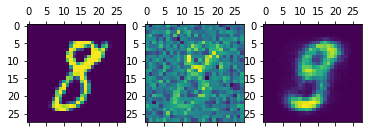

In [10]:
############################ NOISE RECONSTRUCTION ##############################
input_data, label = train_loader.dataset[85] # Random input
corrupt_data = (input_data + torch.randn_like(input_data)*0.5).view(1,784)
prob_vk,prob_hk = sampler(corrupt_data.clone(),k=1)
recon_data = prob_vk.detach()

fig,axs = plt.subplots(1,3)
axs[0].matshow(input_data.view(28,28))
axs[1].matshow(corrupt_data.view(28,28))
axs[2].matshow(recon_data.detach().view(28,28))

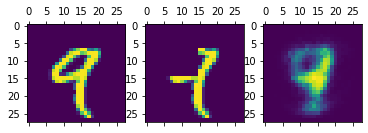

In [11]:
############################## RECONSTRUCTION ##################################
input_data, label = train_loader.dataset[4]
mask = torch.ones_like(input_data)
for i in range(0,15): # Is there a nicer way to create random masks?
    for j in range(0,15):
        mask[0][j][i] = 0

corrupt_data = (input_data*mask).view(1,784)

prob_vk,prob_hk = sampler(corrupt_data.clone(),k=1)
fig,axs = plt.subplots(1,3)
axs[0].matshow(input_data.view(28, 28))
axs[1].matshow(corrupt_data.view(28, 28))
axs[2].matshow(prob_vk.detach().view(28, 28))

Even though this model was trained unsupervised, it is possible to now use it as a pre-trained model and "fit" its hidden layers and output and perform training on that.

In [12]:
############################### CLASSIFIER ####################################
LABEL_SIZE = len(train_dataset.classes)

model = torch.nn.Sequential(rbm,
                            torch.nn.Linear(HIDDEN_SIZE,LABEL_SIZE),)
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_log = []
accuracy_log = []
for t in range(10):
    for v_batch, labels_batch in train_loader:
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(v_batch.view(len(v_batch),VISIBLE_SIZE))

        # Compute and print loss.
        loss = loss_fn(y_pred, torch.nn.functional.one_hot(labels_batch,10)*1.0)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the Tensors it will update (which are the learnable weights
        # of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

    loss_log.append(loss.item())
    print(f"Epoch {t} Loss = {loss.item()}")

    count = 0
    for test_data, test_label in test_loader:
        label_pred = model(test_data.view(1,VISIBLE_SIZE)).argmax()
        if label_pred == test_label:
            count+=1
    accuracy_log.append(count/len(test_dataset))
    print(f"Testing accuracy: {count}/{len(test_dataset)}")

Epoch 0 Loss = 16.344905853271484
Testing accuracy: 8632/10000
Epoch 1 Loss = 8.760297775268555
Testing accuracy: 9035/10000
Epoch 2 Loss = 6.418242931365967
Testing accuracy: 9151/10000
Epoch 3 Loss = 6.33777379989624
Testing accuracy: 9257/10000
Epoch 4 Loss = 5.176335334777832
Testing accuracy: 9301/10000
Epoch 5 Loss = 6.68268346786499
Testing accuracy: 9372/10000
Epoch 6 Loss = 6.2941975593566895
Testing accuracy: 9403/10000
Epoch 7 Loss = 4.240209579467773
Testing accuracy: 9435/10000
Epoch 8 Loss = 4.2346296310424805
Testing accuracy: 9450/10000
Epoch 9 Loss = 7.845439910888672
Testing accuracy: 9457/10000


Text(0.5, 0, 'Epoch')

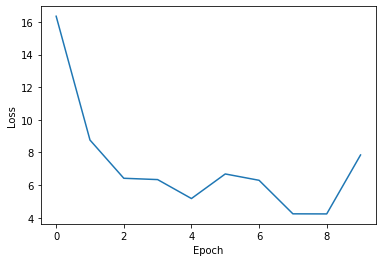

In [13]:
fig, ax = plt.subplots()
plt.plot(loss_log)
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

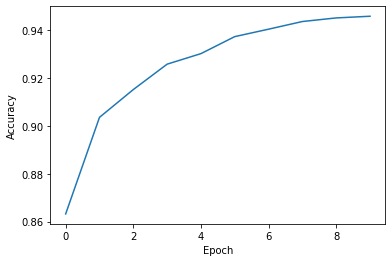

In [14]:
fig, ax = plt.subplots()
plt.plot(accuracy_log)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")